In [1]:
import os
import torch
import random
from PIL import Image
from torchvision.io import read_image
from torchvision import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [2]:
torch.cuda.is_available()

True

## Loading Data

In [3]:
class datasetImport(data.Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.jpg')
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1:].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label

# Analysis

## Data Distribution

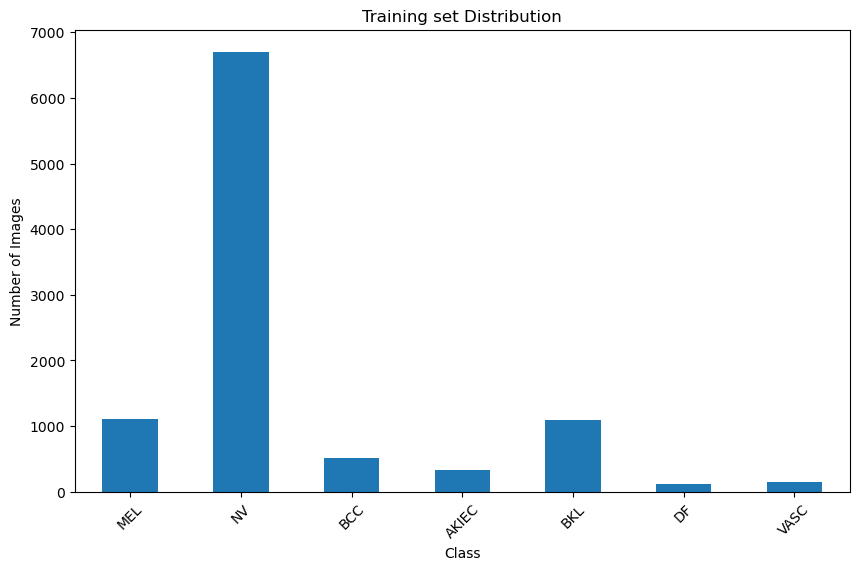

In [4]:
# Read the CSV file
train_annotations_file = "ISIC2018_Task3_Training_GroundTruth.csv"
ground_truth = pd.read_csv(train_annotations_file)

class_distribution = ground_truth.drop(columns=['image']).sum()

# Plot the class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Training set Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

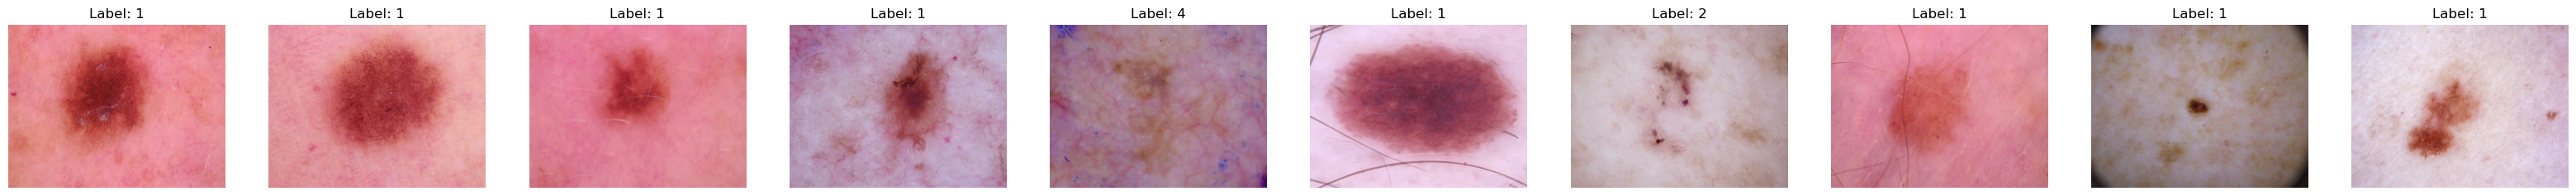

In [5]:
# Training set
train_img_dir = "ISIC2018_Task3_Training_Input"
train_annotations_file = "ISIC2018_Task3_Training_GroundTruth.csv"
train_dataset = datasetImport(img_dir=train_img_dir, annotations_file=train_annotations_file, transform=transforms.ToTensor())

def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(40, 6))
    indices = random.sample(range(len(dataset)), num_images)
    for i, ax in enumerate(axes.flat):
        image, label = dataset[indices[i]]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
show_images(train_dataset, num_images=4)


In [ ]:
from collections import Counter

# **Undersampling implementation:**
def undersample(dataset, num_samples_per_class=None):
  """
  Undersamples the majority class in the training dataset.

  Args:
      dataset: The training dataset.
      num_samples_per_class (optional): Dictionary specifying the desired number of samples per class.
          If None, the function will undersample to balance the classes.

  Returns:
      undersampled_dataset: The undersampled dataset.
  """

  class_counts = Counter(dataset.img_labels)
  # Find the majority class and its count
  majority_class, majority_count = class_counts.most_common(1)[0]

  # If no specific number of samples per class is provided, aim to balance the classes
  if num_samples_per_class is None:
    target_count = min(count for class_name, count in class_counts.items() if class_name != majority_class)
  else:
    target_count = num_samples_per_class.get(majority_class, None)
    if target_count is None:
      raise ValueError("Number of samples per class must be specified for the majority class.")

  # Ensure target count is less than or equal to the majority class count
  if target_count > majority_count:
    raise ValueError("Target count cannot be greater than the majority class count.")

  # Filter indices for the majority class
  majority_class_indices = (dataset.img_labels == majority_class).nonzero().flatten()

  # Randomly sample indices from the majority class to keep
  random_indices = torch.randperm(len(majority_class_indices))[:target_count]
  sampled_indices = majority_class_indices[random_indices]

  # Combine indices from the majority class and other classes
  undersampled_indices = torch.cat((sampled_indices, (dataset.img_labels != majority_class).nonzero().flatten()))

  # Create a new dataset with the undersampled indices
  undersampled_dataset = torch.utils.data.Subset(dataset, undersampled_indices)

  return undersampled_dataset

# Apply undersampling to the training dataset
# train_dataset = undersample(train_dataset)

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Training set
train_img_dir = "ISIC2018_Task3_Training_Input"
train_annotations_file = "ISIC2018_Task3_Training_GroundTruth.csv"
train_dataset = datasetImport(img_dir=train_img_dir, annotations_file=train_annotations_file, transform=transform)

# Validation set
valid_img_dir = "ISIC2018_Task3_Validation_Input"
valid_annotations_file = "ISIC2018_Task3_Validation_GroundTruth.csv"
valid_dataset = datasetImport(img_dir=valid_img_dir, annotations_file=valid_annotations_file, transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)

In [7]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Initialize the model, criterion, and optimizer as before
model = models.resnet18(weights=True)
model.fc = nn.Linear(model.fc.in_features, 7)  # 7 classes for ISIC2018
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

Using device: cuda:0


C:\Users\lehan\anaconda3\envs\newcuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=200, patience=10):
    best_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}')

        if val_loss < best_loss:
            print(f'Validation loss decreased from {best_loss} to {val_loss}. Saving model...')
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break

In [9]:
# Do not change it to True until you want to retrain the network.
Train_mode = True
# Train_mode = False
if Train_mode:
    train_model(model, criterion, optimizer, train_loader, valid_loader)

Epoch 1, Train Loss: 1.3166765734553336, Val Loss: 0.8665394186973572
Validation loss decreased from inf to 0.8665394186973572. Saving model...
Epoch 2, Train Loss: 0.6849894270300865, Val Loss: 0.5824689865112305
Validation loss decreased from 0.8665394186973572 to 0.5824689865112305. Saving model...
Epoch 3, Train Loss: 0.4956433899700642, Val Loss: 0.5271668434143066
Validation loss decreased from 0.5824689865112305 to 0.5271668434143066. Saving model...
Epoch 4, Train Loss: 0.3713273651897907, Val Loss: 0.48047181963920593
Validation loss decreased from 0.5271668434143066 to 0.48047181963920593. Saving model...
Epoch 5, Train Loss: 0.27239745706319807, Val Loss: 0.4746491014957428
Validation loss decreased from 0.48047181963920593 to 0.4746491014957428. Saving model...
Epoch 6, Train Loss: 0.20338239409029485, Val Loss: 0.46252062916755676
Validation loss decreased from 0.4746491014957428 to 0.46252062916755676. Saving model...
Epoch 7, Train Loss: 0.14388501830399036, Val Loss: 0.

In [10]:
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

In [11]:
# test set
test_img_dir = "ISIC2018_Task3_Test_Input"
test_annotations_file = "ISIC2018_Task3_Test_GroundTruth.csv"
test_dataset = datasetImport(img_dir=test_img_dir, annotations_file=test_annotations_file, transform=transform)

# Data loaders
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def evaluate_model(model, data_loader):
    true_labels = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    classification_report_ = classification_report(true_labels, predictions, output_dict=True)
    confusion_matrix_ = confusion_matrix(true_labels, predictions)

    return true_labels, predictions, accuracy, classification_report_, confusion_matrix_

adamtrue_labels, adampredictions, adamaccuracy, adamclassification_report, adamconfusion_matrix = evaluate_model(model, test_loader)
# Print the metrics
print(f"Accuracy: {adamaccuracy:.4f}")
print("Classification Report:\n", adamclassification_report)
print("Confusion Matrix:\n", adamconfusion_matrix)

Accuracy: 0.7765
Classification Report:
 {'0': {'precision': 0.5714285714285714, 'recall': 0.49122807017543857, 'f1-score': 0.5283018867924528, 'support': 171.0}, '1': {'precision': 0.8739583333333333, 'recall': 0.922992299229923, 'f1-score': 0.8978063135366506, 'support': 909.0}, '2': {'precision': 0.5434782608695652, 'recall': 0.5376344086021505, 'f1-score': 0.5405405405405405, 'support': 93.0}, '3': {'precision': 0.5, 'recall': 0.5813953488372093, 'f1-score': 0.5376344086021505, 'support': 43.0}, '4': {'precision': 0.6350710900473934, 'recall': 0.6175115207373272, 'f1-score': 0.6261682242990655, 'support': 217.0}, '5': {'precision': 0.7586206896551724, 'recall': 0.5, 'f1-score': 0.6027397260273972, 'support': 44.0}, '6': {'precision': 0.8695652173913043, 'recall': 0.5714285714285714, 'f1-score': 0.689655172413793, 'support': 35.0}, 'accuracy': 0.7764550264550265, 'macro avg': {'precision': 0.6788745946750486, 'recall': 0.6031700312872313, 'f1-score': 0.6318351817445785, 'support': 1

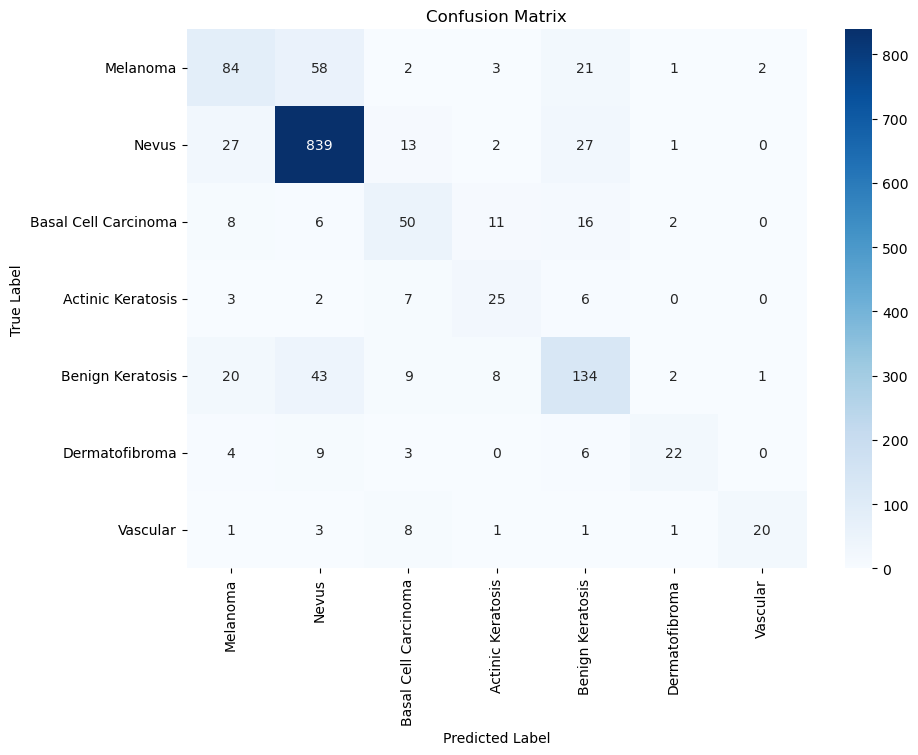

In [14]:
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

cm = confusion_matrix(adamtrue_labels, adampredictions)
class_names = ['Melanoma', 'Nevus', 'Basal Cell Carcinoma', 'Actinic Keratosis', 'Benign Keratosis', 'Dermatofibroma', 'Vascular']

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)

In [15]:
probabilities = []

model.eval() 
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        probabilities.extend(probs.cpu().numpy())

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

n_classes = 7
y_test = label_binarize(test_dataset.img_labels.iloc[:, 1:].values, classes=range(n_classes))
y_score = np.array(probabilities)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

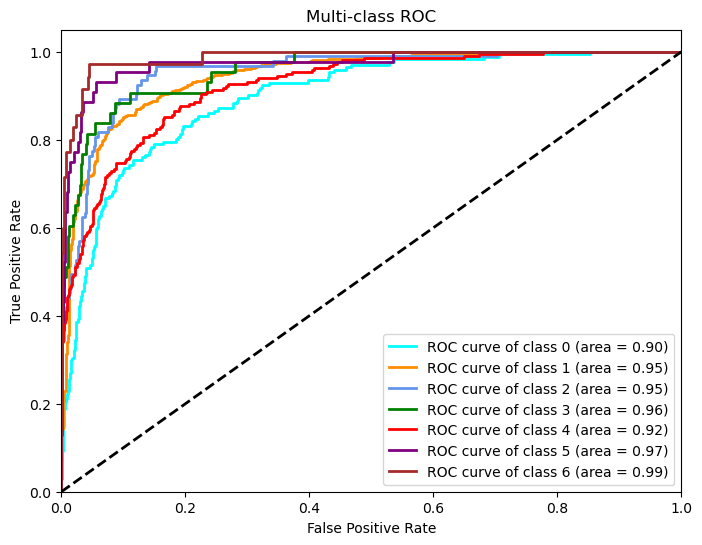

In [17]:
# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Initialize the model, criterion, and optimizer as before
model = models.resnet18(weights=True)
model.fc = nn.Linear(model.fc.in_features, 7)  # 7 classes for ISIC2018
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer2 = optim.AdamW(model.parameters(), lr=1e-3)

C:\Users\lehan\anaconda3\envs\newcuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 

In [19]:
Train_mode = True
# Train_mode = False
if Train_mode:
    train_model(model, criterion, optimizer2, train_loader, valid_loader)

Epoch 1, Train Loss: 0.8200766399502755, Val Loss: 0.5128188729286194
Validation loss decreased from inf to 0.5128188729286194. Saving model...
Epoch 2, Train Loss: 0.5120856329798699, Val Loss: 0.6727694869041443
Epoch 3, Train Loss: 0.4094991788268089, Val Loss: 0.8415668606758118
Epoch 4, Train Loss: 0.33544406294822693, Val Loss: 0.686647891998291
Epoch 5, Train Loss: 0.23817984480410814, Val Loss: 0.8317422866821289
Epoch 6, Train Loss: 0.16884364429861307, Val Loss: 1.5847934484481812
Epoch 7, Train Loss: 0.1608813876286149, Val Loss: 1.2304165363311768
Epoch 8, Train Loss: 0.17617558669298888, Val Loss: 0.6115664839744568
Epoch 9, Train Loss: 0.05952649326063693, Val Loss: 0.6403588652610779
Epoch 10, Train Loss: 0.04792604567483068, Val Loss: 0.6926097869873047
Epoch 11, Train Loss: 0.08392946436069906, Val Loss: 1.2717416286468506
Early stopping triggered.


In [20]:
othertrue_labels, otherpredictions, otheraccuracy, otherclassification_report, otherconfusion_matrix = evaluate_model(model, test_loader)
# Print the metrics
print(f"Accuracy: {otheraccuracy:.4f}")
print("Classification Report:\n", otherclassification_report)
print("Confusion Matrix:\n", otherconfusion_matrix)

Accuracy: 0.7143
Classification Report:
 {'0': {'precision': 0.5263157894736842, 'recall': 0.05847953216374269, 'f1-score': 0.10526315789473684, 'support': 171.0}, '1': {'precision': 0.7748878923766817, 'recall': 0.9504950495049505, 'f1-score': 0.8537549407114625, 'support': 909.0}, '2': {'precision': 0.6923076923076923, 'recall': 0.3870967741935484, 'f1-score': 0.496551724137931, 'support': 93.0}, '3': {'precision': 0.25510204081632654, 'recall': 0.5813953488372093, 'f1-score': 0.35460992907801414, 'support': 43.0}, '4': {'precision': 0.6091370558375635, 'recall': 0.5529953917050692, 'f1-score': 0.5797101449275363, 'support': 217.0}, '5': {'precision': 1.0, 'recall': 0.1590909090909091, 'f1-score': 0.2745098039215686, 'support': 44.0}, '6': {'precision': 0.75, 'recall': 0.5142857142857142, 'f1-score': 0.6101694915254237, 'support': 35.0}, 'accuracy': 0.7142857142857143, 'macro avg': {'precision': 0.6582500672588498, 'recall': 0.4576912456830205, 'f1-score': 0.4677955988852389, 'suppor

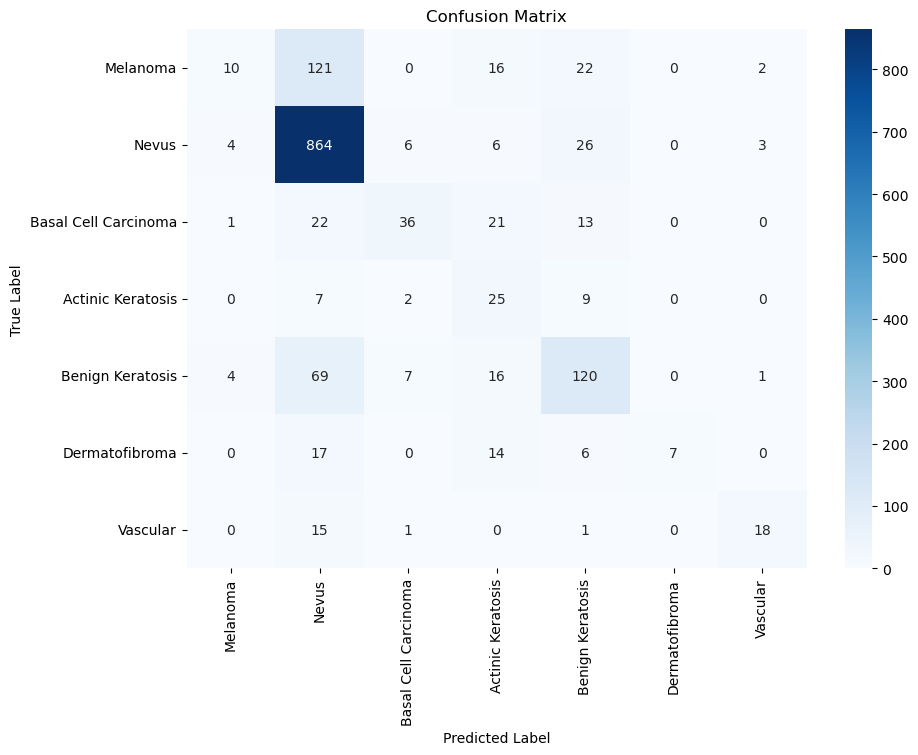

In [21]:
cm = confusion_matrix(othertrue_labels, otherpredictions)

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)

In [45]:
# Initialize the model, criterion, and optimizer as before
model = models.resnet18(weights=True)
model.fc = nn.Linear(model.fc.in_features, 7)  # 7 classes for ISIC2018
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer3 = optim.SGD(model.parameters(), lr=3e-5)

C:\Users\lehan\anaconda3\envs\newcuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
Train_mode = True
# Train_mode = False
if Train_mode:
    train_model(model, criterion, optimizer3, train_loader, valid_loader, patience=2)

Epoch 1, Train Loss: 2.2092616856098175, Val Loss: 2.063119649887085
Validation loss decreased from inf to 2.063119649887085. Saving model...
Epoch 2, Train Loss: 2.0270971059799194, Val Loss: 1.9396806955337524
Validation loss decreased from 2.063119649887085 to 1.9396806955337524. Saving model...
Epoch 3, Train Loss: 1.8676470398902894, Val Loss: 1.8087936639785767
Validation loss decreased from 1.9396806955337524 to 1.8087936639785767. Saving model...
Epoch 4, Train Loss: 1.7375810414552688, Val Loss: 1.6855568885803223
Validation loss decreased from 1.8087936639785767 to 1.6855568885803223. Saving model...
Epoch 5, Train Loss: 1.6311684489250182, Val Loss: 1.597580075263977
Validation loss decreased from 1.6855568885803223 to 1.597580075263977. Saving model...
Epoch 6, Train Loss: 1.5438502222299575, Val Loss: 1.530616283416748
Validation loss decreased from 1.597580075263977 to 1.530616283416748. Saving model...
Epoch 7, Train Loss: 1.4763156980276109, Val Loss: 1.4795712232589722

KeyboardInterrupt: 

In [ ]:
other2true_labels, other2predictions, other2accuracy, other2classification_report, other2confusion_matrix = evaluate_model(model, test_loader)
# Print the metrics
print(f"Accuracy: {other2accuracy:.4f}")
print("Classification Report:\n", other2classification_report)
print("Confusion Matrix:\n", other2confusion_matrix)

In [50]:
  # Create a DataFrame from the data
data = {
      "Metric | ": ["Accuracy | ", "Precision (Avg) | ", "Recall (Avg) | ", "F1-Score (Avg) | "],
      "Model with lr of 3e-5 |": [adamaccuracy*100, adamclassification_report['weighted avg']['precision'], adamclassification_report['weighted avg']['recall'], adamclassification_report['weighted avg']['f1-score']], 
      "Model with lr of 1e-3 |": [otheraccuracy*100, otherclassification_report['weighted avg']['precision'], otherclassification_report['weighted avg']['recall'], otherclassification_report['weighted avg']['f1-score']], 
    
  }
df = pd.DataFrame(data)
print(df)

            Metric |   Model with lr of 3e-5 |  Model with lr of 1e-3 |
0         Accuracy |                 77.645503                71.428571
1  Precision (Avg) |                  0.771039                 0.709100
2     Recall (Avg) |                  0.776455                 0.714286
3   F1-Score (Avg) |                  0.771409                 0.671113
